In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
!pip install --upgrade quantecon
import quantecon as qe
from math import erfc, sqrt

Requirement already up-to-date: quantecon in c:\users\woute\anaconda3\lib\site-packages (0.4.5)


**EXERCISE 2 - SETUP**

In [3]:
θ = 0.21
ν = 0.64
δ = 0.1
β = 0.96
ϕ = 0.5

In [4]:
ρ = 0.9   ## SETTING UP THE MARKOV PROBAILITIES AND STATES FOR WHAT FOLLOWS
σ = 0.02

MC = qe.markov.approximation.tauchen(ρ, σ, n=10)
print(MC)


m=3
sigma_y = np.sqrt( σ**2 / (1-ρ**2) )

x = np.zeros(10)
x[0] = -m*sigma_y
x[9] = m*sigma_y

for xx in range(0,8):
    x[xx+1]=x[xx] + ( x[9] - x[0])/(10-1)

print("The states are:", x)

<bound method MarkovChain.__repr__ of Markov chain with transition matrix 
P = 
[[5.30478170e-01 4.15375002e-01 5.32885772e-02 8.56706028e-04
  1.54439460e-06 2.92857183e-10 5.66213743e-15 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.67966302e-02 4.93930466e-01 3.69971746e-01 3.87971726e-02
  5.03259844e-04 7.25892202e-07 1.09655174e-10 1.66533454e-15
  0.00000000e+00 0.00000000e+00]
 [3.71959075e-03 1.21954964e-01 5.23228103e-01 3.23146274e-01
  2.76615366e-02 2.89198006e-04 3.33562232e-07 4.01295663e-11
  4.44089210e-16 0.00000000e+00]
 [2.52812798e-05 5.78316444e-03 1.54270165e-01 5.43701344e-01
  2.76746317e-01 1.93110204e-02 1.62557651e-04 1.49849563e-07
  1.43532963e-11 1.11022302e-16]
 [2.82551739e-08 4.80546862e-05 8.83083400e-03 1.91241547e-01
  5.54230974e-01 2.32360418e-01 1.31987073e-02 8.93711456e-05
  6.58100220e-08 5.01743092e-12]
 [5.01748193e-12 6.58100220e-08 8.93711456e-05 1.31987073e-02
  2.32360418e-01 5.54230974e-01 1.91241547e-01 8.83083400e-03
  4.8054686

In [5]:
def own_tauchen(rho, sigma_u, b=0., m=3, n=7):  ##SETTING UP THE MARKOV IN A DIFFERENT WAY
    std_y = np.sqrt(sigma_u**2 / (1 - rho**2))

    # top of discrete state space for demeaned y_t
    x_max = m * std_y

    # bottom of discrete state space for demeaned y_t
    x_min = -x_max

    # discretized state space for demeaned y_t
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    # approximate Markov transition matrix for
    # demeaned y_t
    _fill_tauchen(x, P, n, rho, sigma_u, half_step)

    # shifts the state values by the long run mean of y_t
    mu = b / (1 - rho)

    #mc = MarkovChain(P, state_values=x+mu)

    return P

def _fill_tauchen(x, P, n, rho, sigma, half_step):
    for i in range(n):
        P[i, 0] = std_norm_cdf((x[0] - rho * x[i] + half_step) / sigma)
        P[i, n - 1] = 1 - \
            std_norm_cdf((x[n - 1] - rho * x[i] - half_step) / sigma)
        for j in range(1, n - 1):
            z = x[j] - rho * x[i]
            P[i, j] = (std_norm_cdf((z + half_step) / sigma) -
                       std_norm_cdf((z - half_step) / sigma))

def std_norm_cdf(x):
    return 0.5 * erfc(-x / sqrt(2))

In [6]:
MC = own_tauchen(ρ, σ, n=10)

**EXERCISE 2 - SOLUTION OF THE STEADY STATE**

In [7]:
def steady(params, n_bar):
    θ, ν, δ, β, ϕ = params
    
    r_bar = 1/β - (1-δ)
    k_bar = (r_bar/(θ*(n_bar)**ν))**(1/(θ-1)) #( (0.5*ϕ*(-δ)**2 - ϕ*δ - (1-δ)) / (n_bar**ν) )**(1/(θ-1))
    y_bar = k_bar**θ * n_bar**ν
    i_bar = δ * k_bar
    w_bar = ν * k_bar**θ * n_bar**(ν-1)
    c_bar = k_bar**θ * n_bar**ν - i_bar ## - w_bar*n_bar - k_bar*0.5*ϕ*(-δ)**2
    a_bar = (w_bar*n_bar)/c_bar
    
    return r_bar, k_bar, y_bar, i_bar, w_bar, c_bar, a_bar

In [8]:
params = θ, ν, δ, β, ϕ
print(steady(params, 0.6))

(0.14166666666666672, 1.0881001887382777, 0.7340358416091558, 0.10881001887382778, 0.7829715643830996, 0.625225822735328, 0.7513812154696132)


**EXERCISE 3 - VFI**

In [9]:
params = θ, ν, δ, β, ϕ
w_rep = 0.7829715643830996
c_f = 0.01

In [10]:
eps = 0.0001
max_iter = 1000

In [34]:
def V1_fun(k, kp, ee, w_rep, V_guess, params):
    
    θ, ν, δ, β, ϕ = params
    
    state = x[ee]
    E = np.exp(state)
    n = (w_rep/(ν*E*(k**θ)))**(1/(ν-1))
    
    EV = np.dot(V_guess[:],MC[ee,:])
    
    V1 = E*(k**(θ))*(n**(ν)) - w_rep*n - (kp - (1-δ)*k) - k*(ϕ/2)*(kp/k - (1-δ))**2 + β * EV
    
    return V1

In [35]:
nk = 50
k_low = 0 
k_high = 2
k_grid = np.linspace(k_low, k_high, nk)

V = np.zeros((nk,10))
MV = np.zeros((nk,10))
pol = np.zeros_like(V)

crit = 1
itr = 0

while crit > eps and itr < max_iter:
    print('Iteration: {}'.format(itr + 1))
    
    V_new = np.zeros_like(V)
    
    for ii in range(nk): #loop over k grid (now)
        k = k_grid[ii]
        for ee in range(10):
            max_V = -9999999999999
            idx = 0
            
            for jj in range(nk): 
                
                maxim_val = V1_fun(k, k_grid[jj], ee, w_rep, V[jj,:], params)
                if (1-δ)*k > maxim_val-c_f:
                    if max_V < (1-δ)*k:
                        max_V = (1-δ)*k
                        idx = -2
                else:
                    if max_V < maxim_val - c_f:
                        max_V = maxim_val - c_f
                        idx = jj
            
            V_new[ii,ee] = max_V
            if idx > -2:
                pol[ii,ee] = k_grid[int(idx)]
            else:
                pol[ii,ee] = -2
    
    V_new[0,:] = 0
    crit = np.max(np.abs(V - V_new))
    print("the V difference is:", crit)
    
    V = V_new.copy()
    itr += 1

print(V)

Iteration: 1


C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


the V difference is: 1.9374424720750834
Iteration: 2
the V difference is: 0.33090387095103857
Iteration: 3
the V difference is: 0.24727327737669436
Iteration: 4
the V difference is: 0.20626009704134995
Iteration: 5
the V difference is: 0.18040486340387352
Iteration: 6
the V difference is: 0.16116084183556545
Iteration: 7
the V difference is: 0.14584419542749494
Iteration: 8
the V difference is: 0.13293261057676364
Iteration: 9
the V difference is: 0.12179076817315782
Iteration: 10
the V difference is: 0.11202517268611079
Iteration: 11
the V difference is: 0.1033720313674622
Iteration: 12
the V difference is: 0.09574841464978512
Iteration: 13
the V difference is: 0.08898225766054635
Iteration: 14
the V difference is: 0.08292770640196023
Iteration: 15
the V difference is: 0.07746581604423097
Iteration: 16
the V difference is: 0.07254717426965218
Iteration: 17
the V difference is: 0.06809354021459324
Iteration: 18
the V difference is: 0.0640455930266901
Iteration: 19
the V difference is: 

the V difference is: 0.00027409548417267615
Iteration: 148
the V difference is: 0.00026313165960134555
Iteration: 149
the V difference is: 0.00025260638872914853
Iteration: 150
the V difference is: 0.00024250212930754245
Iteration: 151
the V difference is: 0.00023280204079512146
Iteration: 152
the V difference is: 0.00022348995628274082
Iteration: 153
the V difference is: 0.0002145503555475159
Iteration: 154
the V difference is: 0.00020596833918329338
Iteration: 155
the V difference is: 0.00019772960376673865
Iteration: 156
the V difference is: 0.00018982041802306782
Iteration: 157
the V difference is: 0.00018222759992703175
Iteration: 158
the V difference is: 0.0001749384947431487
Iteration: 159
the V difference is: 0.00016794095393013464
Iteration: 160
the V difference is: 0.00016122331489043518
Iteration: 161
the V difference is: 0.0001547743815342173
Iteration: 162
the V difference is: 0.00014858340561652028
Iteration: 163
the V difference is: 0.0001426400688258056
Iteration: 164
t

In [36]:
for ee in range(10):
    max_V = -9999999999999
    idx = 0
    
    for jj in range(nk):
        kp = k_grid[jj]
            
        EV = np.dot(V[jj,:],MC[ee,:])
        maxim_val = -kp + β * EV

        if maxim_val > max_V:
            max_V = maxim_val
            idx = jj
            
    V[0,ee] = max_V
    if max_V >= 0:
        pol[0,ee] = k_grid[int(idx)]

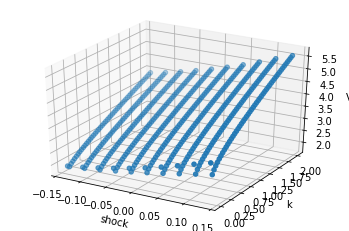

In [37]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, V)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('V');

plt.show()

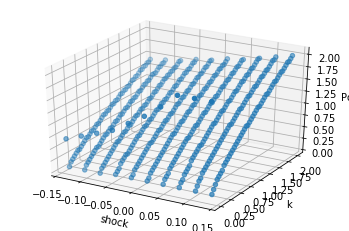

In [38]:
## plot the Value function V(k,ϵ)
x_grid = np.linspace(x[0], x[9], 10)
y_grid = np.linspace(k_low, k_high, nk)

xxx, yyy = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xxx, yyy, pol)
ax.set_xlabel('shock')
ax.set_ylabel('k')
ax.set_zlabel('Pol');

plt.show()

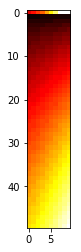

<Figure size 360x360 with 0 Axes>

In [40]:
#print(pol)
fig = plt.figure()
plt.imshow(pol, cmap='hot', interpolation='nearest')
plt.figure(figsize=(5,5))

plt.show()

**EXERCISE 4**

In [41]:
def solve_incum(w, params, nk, k_grid):
    V = np.zeros((nk,10))
    pol = np.zeros_like(V)

    eps = 0.0001
    max_iter = 1000
    
    crit = 1
    itr = 0

    θ, ν, δ, β, ϕ = params
    
    while crit > eps and itr < max_iter:
        print('Iteration: {}'.format(itr + 1))

        V_new = np.zeros_like(V)

        for ii in range(nk): #loop over k grid (now)
            k = k_grid[ii]
            for ee in range(10):
                max_V = -9999999999999
                idx = 0

                for jj in range(nk):  
                    maxim_val = V1_fun(k, k_grid[jj], ee, w, V[jj,:], params)
                    if (1-δ)*k > maxim_val-c_f:
                        if max_V < (1-δ)*k:
                            max_V = (1-δ)*k
                            idx = -2
                    else:
                        if max_V < maxim_val - c_f:
                            max_V = maxim_val - c_f
                            idx = jj

                V_new[ii,ee] = max_V
                if idx > -2:
                    pol[ii,ee] = k_grid[int(idx)]
                else:
                    pol[ii,ee] = -2

        V_new[0,:] = 0
        crit = np.max(np.abs(V - V_new))
        print("the V difference is:", crit)

        V = V_new.copy()
        itr += 1
    
    return V, pol

In [42]:
def solve_entrant(V, pol, params, nk, k_grid):
    
    θ, ν, δ, β, ϕ = params
    
    for ee in range(10):
        max_V = -9999999999999
        idx = 0

        for jj in range(nk):
            kp = k_grid[jj]

            EV = np.dot(V[jj,:],MC[ee,:])
            maxim_val = -kp + β * EV

            if maxim_val > max_V:
                max_V = maxim_val
                idx = jj

        V[0,ee] = max_V
        if max_V >= 0:
            pol[0,ee] = k_grid[int(idx)]
    
    return V, pol

In [43]:
def solve_ex4(w, params, c_e):
    nk = 20
    k_low = 0 
    k_high = 2
    k_grid = np.linspace(k_low, k_high, nk)
    
    V, pol = solve_incum(w, params, nk, k_grid)
    
    V2, pol2 = solve_entrant(V, pol, params, nk, k_grid)
    
    probs = np.ones(10)*0.1 #stationary state to be added here
    integr = np.dot(probs[:],V[0,:])
    
    objective = c_e - integr
    
    return objective

In [44]:
fun = lambda w: solve_ex4(w, params, 0.01)
w_star = optimize.fsolve(fun, [w_rep])

Iteration: 1


C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
C:\Users\woute\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


the V difference is: 1.9374424720750834
Iteration: 2
the V difference is: 0.3305278073964284
Iteration: 3
the V difference is: 0.24722371580194658
Iteration: 4
the V difference is: 0.20630199948754502
Iteration: 5
the V difference is: 0.18042533637652802
Iteration: 6
the V difference is: 0.16075399485409658
Iteration: 7
the V difference is: 0.14590219312331776
Iteration: 8
the V difference is: 0.13248618885093855
Iteration: 9
the V difference is: 0.12150461113898148
Iteration: 10
the V difference is: 0.11203564864575943
Iteration: 11
the V difference is: 0.10340616710535544
Iteration: 12
the V difference is: 0.09576006322675745
Iteration: 13
the V difference is: 0.08893038435010991
Iteration: 14
the V difference is: 0.08282001729503286
Iteration: 15
the V difference is: 0.07733830822328613
Iteration: 16
the V difference is: 0.0724067151878689
Iteration: 17
the V difference is: 0.06794866350229967
Iteration: 18
the V difference is: 0.06390439132603376
Iteration: 19
the V difference is: 

the V difference is: 0.00027353663097962055
Iteration: 148
the V difference is: 0.00026259516051929666
Iteration: 149
the V difference is: 0.00025209134959602864
Iteration: 150
the V difference is: 0.0002420076917273306
Iteration: 151
the V difference is: 0.00023232738070877446
Iteration: 152
the V difference is: 0.0002230342825910725
Iteration: 153
the V difference is: 0.00021411290879491673
Iteration: 154
the V difference is: 0.00020554839029340854
Iteration: 155
the V difference is: 0.00019732645282743988
Iteration: 156
the V difference is: 0.00018943339311494611
Iteration: 157
the V difference is: 0.00018185605601139798
Iteration: 158
the V difference is: 0.0001745818125806764
Iteration: 159
the V difference is: 0.00016759853905190525
Iteration: 160
the V difference is: 0.00016089459660406646
Iteration: 161
the V difference is: 0.00015445881197706512
Iteration: 162
the V difference is: 0.00014828045883952257
Iteration: 163
the V difference is: 0.0001423492399181825
Iteration: 164
t

the V difference is: 0.000790614409349466
Iteration: 122
the V difference is: 0.0007589895888617804
Iteration: 123
the V difference is: 0.0007286297947519671
Iteration: 124
the V difference is: 0.0006994844213510376
Iteration: 125
the V difference is: 0.0006715048878520591
Iteration: 126
the V difference is: 0.0006446445572265702
Iteration: 127
the V difference is: 0.0006188586583997235
Iteration: 128
the V difference is: 0.0005941042115473749
Iteration: 129
the V difference is: 0.0005703399563863343
Iteration: 130
the V difference is: 0.0005475262833503081
Iteration: 131
the V difference is: 0.000525625167515642
Iteration: 132
the V difference is: 0.0005046001051813853
Iteration: 133
the V difference is: 0.00048441605298865653
Iteration: 134
the V difference is: 0.00046503936947939195
Iteration: 135
the V difference is: 0.00044643775900077287
Iteration: 136
the V difference is: 0.00042858021784919487
Iteration: 137
the V difference is: 0.0004114369825760633
Iteration: 138
the V differ

the V difference is: 0.0023804815973162974
Iteration: 95
the V difference is: 0.00228524909978578
Iteration: 96
the V difference is: 0.002193827721380437
Iteration: 97
the V difference is: 0.0021060647672443977
Iteration: 98
the V difference is: 0.002021813684699225
Iteration: 99
the V difference is: 0.001940933812827339
Iteration: 100
the V difference is: 0.0018632901427224624
Iteration: 101
the V difference is: 0.0017887530878972768
Iteration: 102
the V difference is: 0.0017171982643517936
Iteration: 103
the V difference is: 0.0016485062798583527
Iteration: 104
the V difference is: 0.0015825625320351477
Iteration: 105
the V difference is: 0.0015192570148032658
Iteration: 106
the V difference is: 0.0014584841328613152
Iteration: 107
the V difference is: 0.0014001425238028276
Iteration: 108
the V difference is: 0.001344134887553139
Iteration: 109
the V difference is: 0.0012903678227971227
Iteration: 110
the V difference is: 0.0012387516701029
Iteration: 111
the V difference is: 0.00118

the V difference is: 0.007174019440034485
Iteration: 68
the V difference is: 0.006886341217795078
Iteration: 69
the V difference is: 0.0066102687546329975
Iteration: 70
the V difference is: 0.006345324260704999
Iteration: 71
the V difference is: 0.006091050921982699
Iteration: 72
the V difference is: 0.005847011804901214
Iteration: 73
the V difference is: 0.005612788840057448
Iteration: 74
the V difference is: 0.005387981876967984
Iteration: 75
the V difference is: 0.0051722078028628715
Iteration: 76
the V difference is: 0.004965099719321131
Iteration: 77
the V difference is: 0.004766306171383405
Iteration: 78
the V difference is: 0.004575490424267414
Iteration: 79
the V difference is: 0.004392329783563298
Iteration: 80
the V difference is: 0.004216514955126982
Iteration: 81
the V difference is: 0.004047749441353332
Iteration: 82
the V difference is: 0.0038857489709247517
Iteration: 83
the V difference is: 0.0037302409593902297
Iteration: 84
the V difference is: 0.003580963998240705
It

the V difference is: 0.008869013029711326
Iteration: 40
the V difference is: 0.008494230893465016
Iteration: 41
the V difference is: 0.008137119394277637
Iteration: 42
the V difference is: 0.007796610370442103
Iteration: 43
the V difference is: 0.00747172798582163
Iteration: 44
the V difference is: 0.00716157799842021
Iteration: 45
the V difference is: 0.006865338511603092
Iteration: 46
the V difference is: 0.0065822519794274115
Iteration: 47
the V difference is: 0.006311618275911535
Iteration: 48
the V difference is: 0.006052788669725473
Iteration: 49
the V difference is: 0.005805160571683565
Iteration: 50
the V difference is: 0.005568172943682725
Iteration: 51
the V difference is: 0.0053413022753936445
Iteration: 52
the V difference is: 0.005124059049511853
Iteration: 53
the V difference is: 0.004915984628491188
Iteration: 54
the V difference is: 0.004716648505740828
Iteration: 55
the V difference is: 0.004525645872681672
Iteration: 56
the V difference is: 0.0043425954601281624
Itera

the V difference is: 0.005975726219138888
Iteration: 36
the V difference is: 0.00571289603617009
Iteration: 37
the V difference is: 0.005463715852312312
Iteration: 38
the V difference is: 0.005227221201660193
Iteration: 39
the V difference is: 0.005002541877658029
Iteration: 40
the V difference is: 0.004788890978593585
Iteration: 41
the V difference is: 0.004585555262048846
Iteration: 42
the V difference is: 0.004391886646730736
Iteration: 43
the V difference is: 0.004207294733299172
Iteration: 44
the V difference is: 0.004031240233434374
Iteration: 45
the V difference is: 0.0038632292079365804
Iteration: 46
the V difference is: 0.0037028080305381295
Iteration: 47
the V difference is: 0.0035495590186509496
Iteration: 48
the V difference is: 0.0034030966304743338
Iteration: 49
the V difference is: 0.0032630640216368967
Iteration: 50
the V difference is: 0.00312912997801007
Iteration: 51
the V difference is: 0.003000986304738884
Iteration: 52
the V difference is: 0.002878345581239561
Ite

the V difference is: 0.0017927306119607245
Iteration: 46
the V difference is: 0.0017173263523888593
Iteration: 47
the V difference is: 0.0016454047753566847
Iteration: 48
the V difference is: 0.0015767647001543317
Iteration: 49
the V difference is: 0.001511221301340182
Iteration: 50
the V difference is: 0.0014486043631563028
Iteration: 51
the V difference is: 0.0013887567377670607
Iteration: 52
the V difference is: 0.0013315329850476232
Iteration: 53
the V difference is: 0.0012767981735608558
Iteration: 54
the V difference is: 0.0012244268241934364
Iteration: 55
the V difference is: 0.0011743019796575105
Iteration: 56
the V difference is: 0.001126314384733984
Iteration: 57
the V difference is: 0.0010803617637353824
Iteration: 58
the V difference is: 0.001036348183207192
Iteration: 59
the V difference is: 0.0009941834892952528
Iteration: 60
the V difference is: 0.0009537828104821955
Iteration: 61
the V difference is: 0.0009150661174257557
Iteration: 62
the V difference is: 0.00087795783

the V difference is: 0.00023410374544896584
Iteration: 75
the V difference is: 0.00022459984962042157
Iteration: 76
the V difference is: 0.0002154891272985182
Iteration: 77
the V difference is: 0.00020675456269980685
Iteration: 78
the V difference is: 0.00019837995729954372
Iteration: 79
the V difference is: 0.00019034988166666267
Iteration: 80
the V difference is: 0.00018264963106462417
Iteration: 81
the V difference is: 0.00017526518445931671
Iteration: 82
the V difference is: 0.00016818316660494048
Iteration: 83
the V difference is: 0.0001613908128619279
Iteration: 84
the V difference is: 0.0001548759365381791
Iteration: 85
the V difference is: 0.0001486268984876027
Iteration: 86
the V difference is: 0.00014263257876123703
Iteration: 87
the V difference is: 0.0001368823501359806
Iteration: 88
the V difference is: 0.0001313660533504013
Iteration: 89
the V difference is: 0.0001260739738939698
Iteration: 90
the V difference is: 0.00012099682024446778
Iteration: 91
the V difference is: 

the V difference is: 0.00013253901114662625
Iteration: 53
the V difference is: 0.00012463431573439543
Iteration: 54
the V difference is: 0.00011720839885787093
Iteration: 55
the V difference is: 0.00011023084357963953
Iteration: 56
the V difference is: 0.00010367343514894323
Iteration: 57
the V difference is: 9.750995263724249e-05
Iteration: 1
the V difference is: 1.8
Iteration: 2
the V difference is: 0.0267427791590919
Iteration: 3
the V difference is: 0.02195108783502764
Iteration: 4
the V difference is: 0.018467497741059935
Iteration: 5
the V difference is: 0.015972227473330047
Iteration: 6
the V difference is: 0.01380754532804307
Iteration: 7
the V difference is: 0.0109591693384532
Iteration: 8
the V difference is: 0.004839574198149288
Iteration: 9
the V difference is: 0.0037828453218429203
Iteration: 10
the V difference is: 0.0032471462253547134
Iteration: 11
the V difference is: 0.0028113756862930828
Iteration: 12
the V difference is: 0.0024423995806239773
Iteration: 13
the V dif

the V difference is: 0.0016969103832473742
Iteration: 14
the V difference is: 0.0014752893538840794
Iteration: 15
the V difference is: 0.0012873855489119457
Iteration: 16
the V difference is: 0.001126854535733246
Iteration: 17
the V difference is: 0.0009888025876625406
Iteration: 18
the V difference is: 0.000869415611321589
Iteration: 19
the V difference is: 0.000765685416374895
Iteration: 20
the V difference is: 0.0006752092294890488
Iteration: 21
the V difference is: 0.0005964994626632691
Iteration: 22
the V difference is: 0.000529296388416034
Iteration: 23
the V difference is: 0.0004711909541632586
Iteration: 24
the V difference is: 0.00042088818626639934
Iteration: 25
the V difference is: 0.0003772225173701571
Iteration: 26
the V difference is: 0.0003391748792211935
Iteration: 27
the V difference is: 0.0003058744017907511
Iteration: 28
the V difference is: 0.0002765888087892243
Iteration: 29
the V difference is: 0.0002507087772838368
Iteration: 30
the V difference is: 0.00022773026

the V difference is: 0.00010122296009007492
Iteration: 40
the V difference is: 9.285518530655068e-05


In [45]:
print(w_star)

[1.41093805]


**CHECKS**

In [31]:
X = [0,1,2,3,4,5,6,7,8,9]
k = 0.01
kp = 0.21387755
V1_fun(k, kp, 0, w_rep, X, params)

-1.2425553421539313

In [261]:
np.dot(X[:],MC[ee,:])

13.780253245993693

In [259]:
MC[ee,:]

array([3.90429771e-35, 2.08116592e-27, 1.09035811e-20, 5.65165946e-15,
       2.92857227e-10, 1.54439460e-06, 8.56706028e-04, 5.32885772e-02,
       4.15375002e-01, 5.30478170e-01])

In [25]:
nk = 50
k_low = 0.01 
k_high = 10
k_grid = np.linspace(k_low, k_high, nk)
print(k_grid)

[ 0.01        0.21387755  0.4177551   0.62163265  0.8255102   1.02938776
  1.23326531  1.43714286  1.64102041  1.84489796  2.04877551  2.25265306
  2.45653061  2.66040816  2.86428571  3.06816327  3.27204082  3.47591837
  3.67979592  3.88367347  4.08755102  4.29142857  4.49530612  4.69918367
  4.90306122  5.10693878  5.31081633  5.51469388  5.71857143  5.92244898
  6.12632653  6.33020408  6.53408163  6.73795918  6.94183673  7.14571429
  7.34959184  7.55346939  7.75734694  7.96122449  8.16510204  8.36897959
  8.57285714  8.77673469  8.98061224  9.1844898   9.38836735  9.5922449
  9.79612245 10.        ]
